# Training Of Our Volumetric CNN Model on CASIA_FASD

In [1]:
# %load_ext tensorboard
# !pip install wandb
!wandb login ************************************

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import cv2
import psutil
import video_face_utils as futils

In [3]:
df = pd.read_csv('../input/liveness-pp2/SPLIT_CASIA_FASD.csv', header = None)
train_df = df.iloc[df[1].values == True]
test_df = df.iloc[df[1].values == False]
df.head()

,0,1,2,3,4,5
0,DB/8_False_False_20_110_3_0.avi,False,False,20,110,3
1,DB/8_False_False_20_110_3_1.avi,False,False,20,110,3
2,DB/8_False_False_20_110_3_2.avi,False,False,20,110,3
3,DB/8_False_False_20_110_3_3.avi,False,False,20,110,3
4,DB/2_False_False_20_199_0_0.avi,False,False,20,199,0


In [4]:
from tensorflow.keras.utils import to_categorical
def train_gen():
    labels = to_categorical((train_df.iloc[:,-1].values == 0).astype('int'))
    paths = train_df.iloc[:,0].values
    videos = []
    for i in range(len(paths)):
        path = '../input/liveness-pp2/'+paths[i]
        label = labels[i]
        videos.append(futils.read_vid(path, False).reshape(24,100,100,1))
    return np.array(videos, dtype='uint8'), labels

def test_gen():
    labels = to_categorical((test_df.iloc[:,-1].values == 0).astype('int'))
    paths = test_df.iloc[:,0].values
    videos = []
    for i in range(len(paths)):
        path = '../input/liveness-pp2/'+paths[i]
        label = labels[i]
        videos.append(futils.read_vid(path, False).reshape(24,100,100,1))
    return np.array(videos, dtype='uint8'), labels

In [5]:
X_train, y_train = train_gen()
X_test, y_test = test_gen()

In [6]:
BATCH_SIZE = 16
EPOCHS = 30
LR = 0.001
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [7]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="Grad_Project_Liveness_Model", entity="gp_fcaicu")

wandb: Currently logged in as: ahmed-rushdi (gp_fcaicu). Use `wandb login --relogin` to force relogin


In [8]:
# aug = keras.preprocessing.image.ImageDataGenerator(
#     rotation_range=10,
#     fill_mode='reflect',
#     horizontal_flip=True,
# #     preprocessing_function = tf.keras.applications.vgg16.preprocess_input 
# )

lr_red = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=5,
    verbose=1,
    mode='max',
    min_lr=1e-5,
#     min_delta=0.1
)
# def scheduler(epoch, lr):
#     if (epoch+1) % 10:
#         return lr
#     else:
#         return lr * 0.1

# model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
# round(model.optimizer.lr.numpy(), 5)

checkpoint_filepath = 'bestmodel'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

# aug.fit(X_train)

In [9]:
# wandb.config = {
#   "learning_rate": LR,
#   "epochs": EPOCHS,
#   "batch_size": BATCH_SIZE
# }

2022-07-08 23:01:25.642120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 23:01:25.746245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 23:01:25.747099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 23:01:25.749196: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

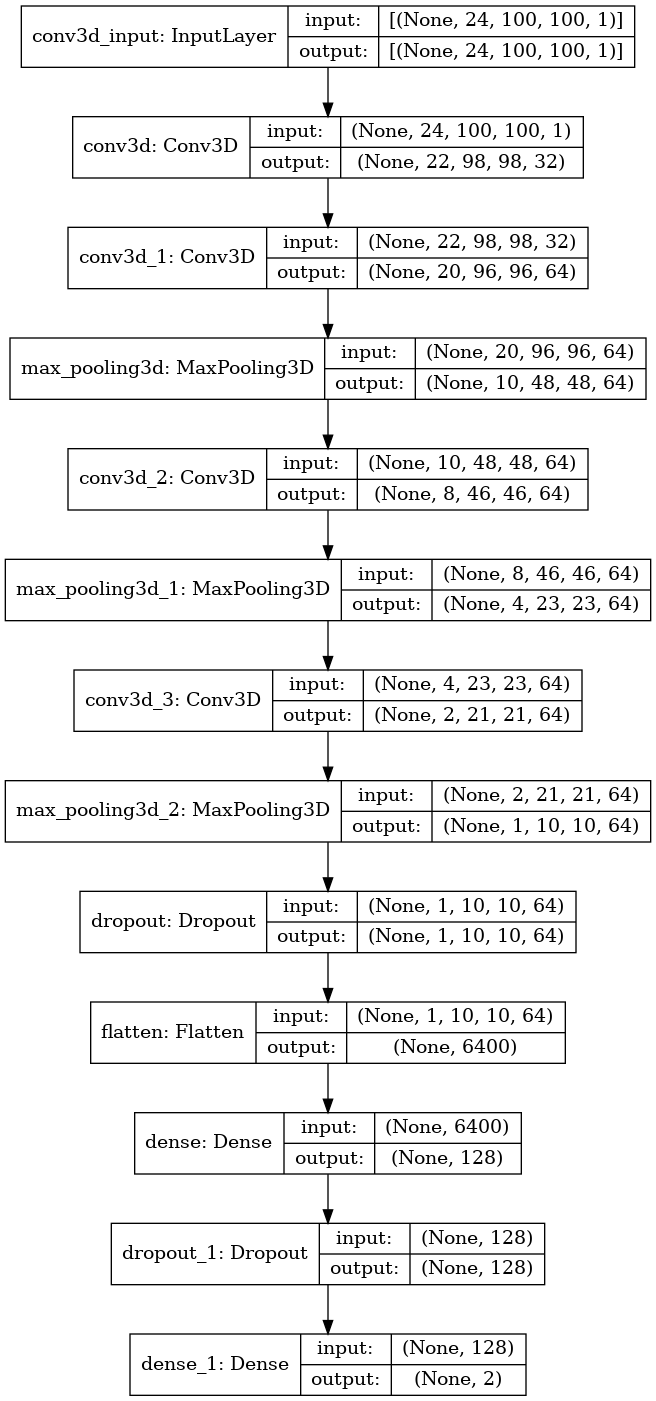

In [10]:
from keras.layers import *
model = keras.Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3),
                activation='relu',
                input_shape=(24,100,100,1)))
model.add(Conv3D(64, (3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, (3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, (3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
keras.utils.plot_model(model, show_shapes=True,)

In [11]:
wandb.log({"model": wandb.Image("./model.png")})

In [12]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=LR), metrics= ['accuracy'])

In [13]:
# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [14]:
X_train.shape

(1717, 24, 100, 100, 1)

In [15]:
X_test.shape

(2485, 24, 100, 100, 1)

In [16]:
model.fit(X_train, y_train,
          batch_size = BATCH_SIZE,
          validation_data = (X_test, y_test),
          epochs=EPOCHS,
          callbacks=[
              lr_red, 
              model_checkpoint_callback,
              WandbCallback()
          ]
          )

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
2022-07-08 23:01:30.887308: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-07-08 23:01:32.374569: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


108/108 [==============================] - 60s 481ms/step - loss: 1.2717 - accuracy: 0.8363 - val_loss: 0.4926 - val_accuracy: 0.8757

Epoch 00001: val_accuracy improved from -inf to 0.87565, saving model to bestmodel
Epoch 2/30
108/108 [==============================] - 50s 464ms/step - loss: 0.1512 - accuracy: 0.9435 - val_loss: 0.2447 - val_accuracy: 0.9272

Epoch 00002: val_accuracy improved from 0.87565 to 0.92716, saving model to bestmodel
Epoch 3/30
108/108 [==============================] - 50s 465ms/step - loss: 0.0743 - accuracy: 0.9796 - val_loss: 0.4315 - val_accuracy: 0.9143

Epoch 00003: val_accuracy did not improve from 0.92716
Epoch 4/30
108/108 [==============================] - 50s 465ms/step - loss: 0.0626 - accuracy: 0.9761 - val_loss: 0.4065 - val_accuracy: 0.9320

Epoch 00004: val_accuracy improved from 0.92716 to 0.93199, saving model to bestmodel
Epoch 5/30
108/108 [==============================] - 50s 465ms/step - loss: 0.0590 - accuracy: 0.9802 - val_loss: 0.

In [17]:
import keras.backend as K
print(K.eval(model.optimizer.lr))

2.7e-05


In [18]:
model.load_weights(checkpoint_filepath)
model.fit(X_train, y_train,
          batch_size = BATCH_SIZE,
          validation_data = (X_test, y_test),
          epochs=EPOCHS,
          callbacks=[
#               lr_red, 
              model_checkpoint_callback,
              WandbCallback()
          ]
          )
model.load_weights(checkpoint_filepath)
model.save('my_model.h5')

Epoch 1/30
108/108 [==============================] - 51s 474ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.4647 - val_accuracy: 0.9477

Epoch 00001: val_accuracy improved from 0.94648 to 0.94769, saving model to bestmodel
Epoch 2/30
108/108 [==============================] - 50s 464ms/step - loss: 0.0709 - accuracy: 0.9802 - val_loss: 0.2965 - val_accuracy: 0.9348

Epoch 00002: val_accuracy did not improve from 0.94769
Epoch 3/30
108/108 [==============================] - 50s 464ms/step - loss: 0.0531 - accuracy: 0.9889 - val_loss: 0.4225 - val_accuracy: 0.9272

Epoch 00003: val_accuracy did not improve from 0.94769
Epoch 4/30
108/108 [==============================] - 50s 465ms/step - loss: 0.0944 - accuracy: 0.9720 - val_loss: 0.3090 - val_accuracy: 0.9344

Epoch 00004: val_accuracy did not improve from 0.94769
Epoch 5/30
108/108 [==============================] - 50s 464ms/step - loss: 0.0343 - accuracy: 0.9901 - val_loss: 0.3754 - val_accuracy: 0.8640

Epoch 00005: val_ac

In [19]:
y_p = model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis= 1), y_p.argmax(axis= 1)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1896
           1       0.91      0.91      0.91       589

    accuracy                           0.96      2485
   macro avg       0.94      0.94      0.94      2485
weighted avg       0.96      0.96      0.96      2485



In [20]:
wandb.log({"classification_report": classification_report(y_test.argmax(axis= 1), y_p.argmax(axis= 1))})
wandb.finish()

accuracy,▁▆▇▇▇▇████▄▇█████████▇▇███▇▇████▇▇██████
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▂▁▁▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁
lr,████████████████▃▃▃▃▃▁▁▁▁▁▁▁▁▁
val_accuracy,▂▆▆▆▆▆▇▇▆▇▆▆▇▇▇▇▇▇▇▇█▆▆▁█▇▃▇▇▆▆▆▄▇▆▇█▇██
val_loss,▄▂▃▁▂▂▄▂█▃▄▂▄▄▄▄▄▅▅▅▄▂▂▃▂▄▂▃▃▅▅▇▆▃▄▄▃▅▃▄
accuracy,0.99884
best_epoch,4
best_val_loss,0.19796
classification_report,precis...
epoch,29
